##EXPLORING AUDIO ONSET DETECTION WITH MACHINE LEARNING 

This  work  aims  to  further  explore  the  task  of  
Audio Onset Detection with deep learning, presenting a novel Convolutional  Recurrent  Neural  Network (CRNN) architecture  for  Musical Onset  Detection.  In  particular, the proposed  architecture has been trained with different hyper-parameter tuning and CNN kernel filters size in order to find the best combination of parameters in terms of performances. Two different dataset have been used for the scope of the project, *Leveau* dataset [1] and the merge of it with *Holzapfel* dataset [2].The model has been been trained with two different input, **spectrogram** and **log-normalized  Mel  Band  spectrogram**. 

[1]: http://www.tsi.telecom-paristech.fr/aao/en/2011/07/13/onset_leveau-a-database-for-onset-detection/
[2]: Holzapfel, André, et al. "Three dimensions of pitched instrument onset detection." IEEE Transactions on Audio, Speech, and Language Processing 18.6 (2009): 1517-1527.

## DATASET USED IN THIS NOTEBOOK

In this notebook are reports the networks and the dataset used considering **Leveu + Holzapfel** dataset and **spectrogram** input. 

Please, go through the notebook carefully to change paths according to you own directories. 

The notebook is divided in two sections: 
- Extraction of features (magnitude and phase for the spectrogram)
- Neural Network: 
  - Squared Neural Network (kernel filter size: 3X3)
  - High Neural Network (kernel filter size: 2x6)
  - Wide Neural Network (kernel filter size: 6x2)

## Extraction of features

The following instruction will extract magnitude and phase from the spectrogram and the label which we will used for training and testing the networks as ground truth. 


First, lets make sure we are using Tensorflow 2.0 and we have a GPU available. 

In [0]:
%tensorflow_version 2.x

In [48]:
import tensorflow
print(tensorflow.__version__)

2.2.0-rc2


In [0]:
# we use %%capture for supressing the output of this cell
%%capture

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [50]:
#@title
#check for the GPU
import psutil
import humanize
import os
import GPUtil as GPU

def printm():
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.6 GB  | Proc size: 510.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


Are the data are saved inside a Google Drive folder. Change it or remove it if your data are saved somewhere else. 

In [51]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#lets define all the module and paths we will need
import os
import numpy as np
import scipy.io.wavfile as wav
from sklearn import preprocessing
from sklearn.externals import joblib
from numpy import genfromtxt

#dataset base folder path
dataset_folder = os.path.join('drive/My Drive/dataset_MIR/final_dataset_try/')
#audio file folder path
wav_path = dataset_folder + 'wav_files/'
#spectrogram folder path (the spectrogram will be saved inside this folder)
spect_path = dataset_folder + 'spectogram/'
#spectrogrma normalized folder path (the normalized spectrogram will be saved inside this folder)
norm_folder_path = dataset_folder + 'Spect_norma/'
#file for weight normalization
normalized_features_wts_file = dataset_folder  + 'spec_wts'
#label folder path (the label extracted will be saved inside this folder)
label_path = dataset_folder + 'labels/'
#csv label file folder pth
csv_path = dataset_folder + 'txt_files/'

Lets define some variables and data we wil need in the following instructions.

In [53]:
eps = np.spacing(np.float(1e-16))
#window length
win_len = 512
#hop size length
hop_len = 256
#FFT 
nfft = 512
#sample rate
fs = 44100
#max length considered foor the audio file 
aud_max_len_samples = 15 * fs  
max_frames = int(np.ceil((aud_max_len_samples - win_len) / float(hop_len)))
#max number of frames
print("Max number of frames in a file: {}".format(max_frames))
#frame resolution
frame_res = fs / float(hop_len)

Max number of frames in a file: 2582


Lets define all the functions we will need for the extraction of the spectrograms. 

In [0]:
#function to create folder
def create_folder(folder_name):
    '''
    The function create a folder (if it already does not exist) with the name specified as input parameter into the current path
    Parameters:
    -----------
        :folder_name: name of the folder
    '''
    if not os.path.exists(folder_name):
        print('{} folder does not exist, creating it.'.format(folder_name))
        os.makedirs(folder_name)

In [0]:
#creation of folders we will need (spectrogram folder, normalized spectrogrtam folder, label folder)
create_folder(spect_path)
create_folder(norm_folder_path)
create_folder(label_path)

In [0]:
def load_audio(audio_path):
    '''
    The function _load_audio loads an audio file into an array.
    If the exceeds the length of maximum samples, it get re-size to the maximum samples length,
    otherwise it is zero padded.
    Parameters:
    ------------
        :audio_path: the path where the file is saved
    Returns:
    ----------
        :tuple containing array of audio sampled (audio) and sampling frequency (fs)
    '''
    fs, audio = wav.read(audio_path)
    #print("Fs: {}, audio shape: {}".format(fs, audio.shape))
    audio = audio / 32768.0 + eps  # maxim integer and bit coding
    # if the number of audio samples are less than the maximum samples needed, zero_padding the samples
    # if they are more, make the array of the same dimensions of the maximum samples needed
    audio = audio.reshape(audio.shape[0], 1)
    if audio.shape[0] < aud_max_len_samples:
         zero_pad = np.zeros((aud_max_len_samples - audio.shape[0], audio.shape[1]))
         audio = np.vstack((audio, zero_pad))
    elif audio.shape[0] > aud_max_len_samples:
         audio = audio[:aud_max_len_samples, :]
    return audio, fs

In [0]:
def spectrogram(audio_in):
    '''
    The function extracts the spectrogram of the audio file given as input parameter
    Parameters:
    -----------
    :audio_in: audio samples
    '''
    _nb_ch = audio_in.shape[1]
    #instatiation of hanning window of size self._win_len, repeating the window for each channel (only one channel in this case)
    hann_win = np.repeat(np.hanning(win_len)[np.newaxis].T, _nb_ch, 1)
    # only positive bins
    nb_bins = int(nfft / 2)
    spectra = np.zeros((max_frames, nb_bins, _nb_ch), dtype=complex)
    for ind in range(max_frames):
        start_ind = int(ind * hop_len)
        aud_frame = audio_in[start_ind + np.arange(0, win_len), :] * hann_win
        spectra[ind] = np.fft.fft(aud_frame, n=nfft, axis=0, norm='ortho')[:nb_bins, :]
    return spectra

In [0]:
def extract_spectogram(audio_filename, file, file_count, spect_path):
    '''
    The function handle the extraction of the spectrogram of the input file and save in in the feature directory
    Parameters:
    -----------
        :audio_filename: the name of the file for which the spectrogram is extracted
    '''

    # loading the sound
    audio_in, fs = load_audio(audio_filename)
    #extract the spectrogram
    spec = spectrogram(audio_in)
    print("Audio spectogram shape: {}".format(spec.shape))
    file_name = audio_filename.split('/')[-1]
    path = spect_path + file_name
    #save the spectrogram as npy file inside the spectrogram folder
    np.save(path, spec.reshape(max_frames, -1))

    return spec

In [0]:
#function to read csv file and extract the labels
def read_desc_file(file_name):
  '''
  The function extract the label from the csv file and save them inside the array labels.
  Parameters:
  ---------------
  Input:
  :file_name: the path of the file where to extract thr label from
  Output
  :labels: label array to return
  '''
  labels = genfromtxt(file_name, delimiter=',')
  return labels

In [0]:
#function to extract the label from file and save them inside the se_label. 
def get_labels_for_file(desc_file):
  '''
  The function saved all the label inside the array se_label. 
  For each label extracted from the desc_file, it is calculated the frame where the onset is active and saved as 1 in the array se_label. 
  Input paramaters:
  ----------------------
  :desc_file: label file for the audio file considered
  Return:
  -----------
  se_label: array describing the audio file where 1 means onset present on the frame and 0 means no audio onset present in the audio file
  '''
  onset_array = []
  se_label = np.zeros(max_frames)
  for i in range(len(desc_file)):
    onset_frame = int(np.floor(float(desc_file[i]) * frame_res))
    if onset_frame < max_frames:
      onset_array.append(onset_frame)
      se_label[onset_frame] = 1

  return se_label

In [0]:
#normalization of feature 
def normalize_feature(spect_path, normalized_features_wts_file, norm_folder_path):
    '''
    The function normalize the features, calculating thr weight on the training test and applying the transofrmation to all the dataset. 
    Input parameters:
    --------------------
    :spect_path: spectrogram path 
    :normalized features_wts_file: file where the weights will be saved
    :norm_fodler_path: normalized spectrogram folder path 
    '''

    spec_scaler = preprocessing.StandardScaler()
    train_cnt = 0

    for file_cnt, file_name in enumerate(os.listdir(spect_path)):
        if 'training_' in file_name and file_name != '.DS_Store':
            print(file_cnt, train_cnt, file_name)
            feat_file = np.load(os.path.join(spect_path, file_name))
            spec_scaler.partial_fit(np.concatenate((np.abs(feat_file), np.angle(feat_file)), axis=1))
            del feat_file
            train_cnt += 1
            # check point, saving the feature scaling (normalization) to a file on a disk

    joblib.dump(
        spec_scaler,
        normalized_features_wts_file
    )
    print("Weighthed count on {} training file".format(train_cnt))

    print('Normalizing feature files')
    for file_cnt, file_name in enumerate(os.listdir(spect_path)):
        if file_name != '.DS_Store':
            print(file_cnt, file_name)
            feat_file = np.load(os.path.join(spect_path, file_name))
            feat_file = spec_scaler.transform(np.concatenate((np.abs(feat_file), np.angle(feat_file)), axis=1))
            print("Feature file shape: {}".format(feat_file.shape))
            np.save(
                os.path.join(norm_folder_path, file_name),
                feat_file
            )
            del feat_file

    print('normalized files written to {} folder and the scaler to {}'.format(
        norm_folder_path, normalized_features_wts_file))

    print("Normalized {} files ".format(file_cnt))

Now, lets have a look at the list of file we are going to use in this notebook 

In [62]:
file_count = 0
print("File that will be processed: ")
for file in os.listdir(wav_path):
    if not file.startswith('.'):
        print(file)
        file_count += 1

print("Total number of file in dataset: {}".format(file_count))

File that will be processed: 
training_DiverseTaksim_pt1.wav
training_SummerTogether.wav
training_kemence_08.wav
training_Guitar_Licks_06-11.wav
training_tabla.wav
training_Cello_Suite_Preludium.wav
test_mixtures_rock1.wav
training_oud_1.wav
training_Guitar_Licks_51-10.wav
training_violin_hoochie.wav
test_ne_se04.wav
training_trumpet_02.wav
training_sax_george.wav
training_ne_icm13.wav
training_piano_mussorgsky.wav
training_Guitar_Licks_06-12.wav
training_Jaillet64.wav
test_tambourine.wav
training_piano_autumn.wav
training_piano_02.wav
test_ta_1mc08.wav
training_violin2.wav
test_piano_p5.wav
training_ta_1eb08.wav
training_celloTaksim_pt1.wav
training_trumpet4.wav
training_bongo1.wav
training_ta_1eb03.wav
training_piano_08.wav
training_piano_p3.wav
training_violin3.wav
training_trumpet_chetbaker.wav
test_triangle.wav
training_Guitar_Licks_07-11.wav
training_ud_06.wav
training_clarinet1.wav
training_ud_03.wav
test_oud_taksimleri_pt1.wav
training_violin1.wav
training_Guitar_Licks_15-05.wa

In [63]:
file_count = 0

#extracting spectogram for each file
for file in os.listdir(wav_path):
    if not file.startswith('.'):
      file_path = os.path.join(wav_path, file)
      extract_spectogram(file_path, file, file_count, spect_path)
      file_count += 1

print("File processed: {}".format(file_count))

Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  del sys.path[0]


Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (2582, 256, 1)
Audio spectogram shape: (

In [0]:
#normalizing feature for each filec
normalize_feature(spect_path, normalized_features_wts_file, norm_folder_path)

0 0 training_kemence_08.wav.npy
1 1 training_leveau_piano1.wav.npy
4 2 training_leveau_pop1.wav.npy
5 3 training_Guitar_Licks_06-12.wav.npy
6 4 training_sax_george.wav.npy
7 5 training_DiverseTaksim_pt1.wav.npy
8 6 training_SummerTogether.wav.npy
9 7 training_tabla.wav.npy
10 8 training_leveau_guitar2.wav.npy
11 9 training_Guitar_Licks_06-11.wav.npy
12 10 training_Cello_Suite_Preludium.wav.npy
13 11 training_Guitar_Licks_51-10.wav.npy
14 12 training_synthbass1.wav.npy
15 13 training_leveau_cello1.wav.npy
16 14 training_oud_1.wav.npy
17 15 training_violin_hoochie.wav.npy
18 16 training_ne_icm13.wav.npy
20 17 training_trumpet_02.wav.npy
21 18 training_Jaillet64.wav.npy
22 19 training_piano_mussorgsky.wav.npy
23 20 training_violin2.wav.npy
24 21 training_piano_02.wav.npy
26 22 training_leveau_distguit1.wav.npy
27 23 training_distguit1.wav.npy
28 24 training_celloTaksim_pt1.wav.npy
29 25 training_ta_1eb08.wav.npy
30 26 training_ud_06.wav.npy
31 27 training_bongo1.wav.npy
32 28 training_tec

In [0]:
#label extraction
for file_cnt, file_name in enumerate(os.listdir(csv_path)):
  if file_name != '.DS_Store':
    print('file_cnt {}, file_name {}'.format(file_cnt, file_name))
    desc_file = read_desc_file(os.path.join(csv_path, file_name))
    #giving the same name extension to the file in order to make easier the processing of the file in the future instructions
    wav_filename = '{}.wav'.format(file_name.split('.')[0])
    labels = get_labels_for_file(desc_file)
    #reshape of the file to be processed correctly for the networks
    labels = labels.reshape(labels.shape[0], 1)
    print("Label file shape: {}".format(labels.shape))
    np.save(os.path.join(label_path, wav_filename), labels)

print("File which have been processed: ", file_cnt)

file_cnt 0, file_name test_mixtures_rock1.txt
Label file shape: (2582, 1)
file_cnt 1, file_name training_violin_hoochie.txt
Label file shape: (2582, 1)
file_cnt 2, file_name training_leveau_distguit1.csv
Label file shape: (2582, 1)
file_cnt 3, file_name training_Guitar_Licks_51-10.txt
Label file shape: (2582, 1)
file_cnt 4, file_name training_kemence_08.txt
Label file shape: (2582, 1)
file_cnt 5, file_name training_tabla.txt
Label file shape: (2582, 1)
file_cnt 6, file_name training_DiverseTaksim_pt1.txt
Label file shape: (2582, 1)
file_cnt 7, file_name test_leveau_guitar3.csv
Label file shape: (2582, 1)
file_cnt 8, file_name training_Cello_Suite_Preludium.txt
Label file shape: (2582, 1)
file_cnt 9, file_name training_leveau_classic2.csv
Label file shape: (2582, 1)
file_cnt 10, file_name training_SummerTogether.txt
Label file shape: (2582, 1)
file_cnt 11, file_name training_leveau_rock1.csv
Label file shape: (2582, 1)
file_cnt 12, file_name training_Guitar_Licks_06-11.txt
Label file sh

## Neural Network - Training and Evaluation

In this part of the code, the different neural network will be trained and evaluate. In particular, we are going to train three different CRNN hyper-paramater: 
- Squared (kernel filter 3x3)
- High (kernel filter 6x2)
- Wide (kernel filter 2x6)


Each of them used different kernel filter size and each of them will be trained with different combination of batch size and sequence lenght in order to find the combination which give the best performance. 
The network will be evaluated in terms of accurcay and F1-score and the relatives confusion matrices will be printed. 

### Definition of hyper-parameter

CRNN - In the next sections we will define the hyper-paramater which will be used in ecah different network which we will train and evaluate (such as CNN units, RNN units, FC units, etc.) together with teh generator of the training batches and function to collect ground truth labels. 
Further details of the network can be found in the report LINK TO REPORT 

In [0]:
#collection of the ground truth label for the test dataset
def collect_test_labels(_data_gen_test, _data_out, quick_test):
     '''
     The function collect the label for the ground truth. 
     Input parameters: 
      ---------------------
      :_data_gen_test: generator for the test dataset
      : _data_out: data output
      : quick_test: 1 for quick test, 0 for no quick test
      Return:
      ------------
      gruund truth label
     '''

     nb_batch = 1 if quick_test else _data_gen_test.get_total_batches_in_data()
     batch_size = _data_out[0]
     gt_sed = np.zeros((nb_batch * batch_size, _data_out[1], _data_out[2]))
     cnt = 0
     for tmp_feat, tmp_label in _data_gen_test.generate():
         gt_sed[cnt * batch_size:(cnt + 1) * batch_size, :, :] = tmp_label[0]
         cnt = cnt + 1
         if cnt == nb_batch:
             break
     return gt_sed.astype(int)

Definition of hyper-parameter used in the network. 
Please consider that nb_epochs, sequence length and batch size we will now be set to 1 but they will be changed in the following instructions. 
Different combinations well be used in order to find the best performance combinations, which in the future will be set in this dictionary as well. Right now they are only defined for future implementation and set to 1.

In [0]:
# Parameters used in the feature extraction, neural network model, and training the CRNN network can be changed here.

#function to get parameters for the model
def get_params():
    '''
    Function to get parametsr of the model
    Return:
    --------
        :params: dictionary with parameters specified according to dataset and training model
    '''
    params = dict(
        quick_test=False,    # To do quick test. Trains/test on small subset of dataset

        
        nfft=512,                 # FFT/window length size

        # CRNN Model parameters
        sequence_length=1,        # Feature sequence length
        batch_size=1,             # Batch size 
        dropout_rate=0.0,         # Dropout rate, constant for all layers
        nb_cnn2d_filt=64,         # Number of CNN nodes, constant for each layer
        pool_size=[8, 8, 2],      # CNN pooling, length of list = number of CNN layers, list value = pooling per layer
        rnn_size=[128, 128],      # RNN contents, length of list = number of layers, list value = number of nodes
        fnn_size=[128],           # FNN contents, length of list = number of layers, list value = number of nodes
        loss_weights=[1.],        # weigths
        nb_epochs=1,              # Train for maximum epochs (one forward pass and one backward pass for all training examples)
                          
    )

    for key, value in params.items():
        print("{}: {}".format(key, value))
    return params


In [0]:
# Data generator for training batch size 

import numpy as np
from numpy.random import seed
seed(1)
import os
from IPython import embed
from collections import deque
import random


class DataGenerator(object):
    def __init__(
            self, datagen_mode='train', batch_size=4, seq_len=216,
            shuffle=True, nfft=512, extra_name=''
    ):

        self._datagen_mode = datagen_mode
        self._batch_size = batch_size
        self._seq_len = seq_len
        self._shuffle = shuffle
        self._label_dir = os.path.join(dataset_folder, 'labels')
        self._feat_dir = os.path.join(dataset_folder, 'Spect_norma')

        self._filenames_list = list()
        self._nb_frames_file = None                   # Assuming number of frames in feat files are the same
        self._feat_len = None
        self._nb_ch = 2                               #(multiply per due )
        self._label_len = None                        
        self._nb_classes = 1
        self._get_label_filenames_sizes()


        self._batch_seq_len = self._batch_size*self._seq_len
        self._circ_buf_feat = None
        self._circ_buf_label = None


        self._nb_total_batches = int(np.floor((len(self._filenames_list) * self._nb_frames_file /
                                               float(self._seq_len * self._batch_size))))

    #function to get labels shapes and features shape
    def get_data_sizes(self):
        '''
        Function to retrieve information regarding features shape and label shape.
        Returns:
        --------
            : feat_shape and label_shape, tuple and list of of label and features shapes
        '''
        #features shape
        feat_shape = (self._batch_size, self._nb_ch, self._seq_len, int(self._feat_len))
        #first label for class
        label_shape = (self._batch_size, self._seq_len, self._nb_classes)

        return feat_shape, label_shape

    #function to get total number of batches in data
    def get_total_batches_in_data(self):
        '''
        Function to the total number of batches
        Return:
        --------
            : total number of batches
        '''
        print("Total number of batches in {}: {}".format(self._datagen_mode, self._nb_total_batches))
        return self._nb_total_batches

    #function to get information according to the dataset
    def _get_label_filenames_sizes(self):
        '''
        The function retrieves all the file belonging to the specified dataset type
        '''
        training_file_count = 0

        for filename in os.listdir(self._label_dir):
            if self._datagen_mode in filename:
                training_file_count += 1
                self._filenames_list.append(filename)

        temp_feat = np.load(os.path.join(self._feat_dir, self._filenames_list[0]))

        #number of frames per file and features length
        self._nb_frames_file = temp_feat.shape[0]
        self._feat_len = temp_feat.shape[1] / self._nb_ch
      
        temp_label = np.load(os.path.join(self._label_dir, self._filenames_list[0]))
        #label length 
        self._label_len = temp_label.shape[-1]
    
        return

    #genearator
    def generate(self):
        """
        Generates batches of samples
        :return:
        """

        while 1:
            if self._shuffle:
                random.shuffle(self._filenames_list)

            # Ideally this should have been outside the while loop. But while generating the test data we want the data
            # to be the same exactly for all epoch's hence we keep it here.
            self._circ_buf_feat = deque()
            self._circ_buf_label = deque()

            file_cnt = 0

            for i in range(self._nb_total_batches):

                # load feat and label to circular buffer. Always maintain at least one batch worth feat and label in the
                # circular buffer. If not keep refilling it.
                
                #creation of the batches.
                while len(self._circ_buf_feat) < self._batch_seq_len:


                    temp_feat = np.load(os.path.join(self._feat_dir, self._filenames_list[file_cnt]))
                    temp_label = np.load(os.path.join(self._label_dir, self._filenames_list[file_cnt]))


                    for row_cnt, row in enumerate(temp_feat):

                        self._circ_buf_feat.append(row)
                        self._circ_buf_label.append(temp_label[row_cnt])

                    file_cnt = file_cnt + 1

                # Read one batch size from the circular buffer
                feat = np.zeros((self._batch_seq_len, int(self._feat_len) * self._nb_ch))
                label = np.zeros((self._batch_seq_len, self._label_len))

                for j in range(self._batch_seq_len):
                    feat[j, :] = self._circ_buf_feat.popleft()
                    label[j, :] = self._circ_buf_label.popleft()
                feat = np.reshape(feat, (self._batch_seq_len, int(self._feat_len), self._nb_ch))


                # Split to sequences
                # making the data the same dimensions as the labels and the features
                feat = self._split_in_seqs(feat)
                label = self._split_in_seqs(label)

                yield feat, label

    def _split_in_seqs(self, data):
        if len(data.shape) == 1:
            if data.shape[0] % self._seq_len:
                data = data[:-(data.shape[0] % self._seq_len), :]
            data = data.reshape((int(data.shape[0] / self._seq_len), self._seq_len, 1))
        elif len(data.shape) == 2:
            if data.shape[0] % self._seq_len:
                data = data[:-(data.shape[0] % self._seq_len), :]
            data = data.reshape((int(data.shape[0] / self._seq_len), self._seq_len, data.shape[1]))
        elif len(data.shape) == 3:
            if data.shape[0] % self._seq_len:
                data = data[:-(data.shape[0] % self._seq_len), :, :]
            data = data.reshape((int(data.shape[0] / self._seq_len), self._seq_len, data.shape[1], data.shape[2]))
        else:
            print('ERROR: Unknown data dimensions: {}'.format(data.shape))
            exit()
        return data





In [0]:
#label reshape
def reshape_3Dto2D(A):
    return A.reshape(A.shape[0] * A.shape[1], A.shape[2])


In [69]:
#lets get the parameters which we will used for the network. 
params = get_params()

quick_test: False
nfft: 512
sequence_length: 1
batch_size: 1
dropout_rate: 0.0
nb_cnn2d_filt: 64
pool_size: [8, 8, 2]
rnn_size: [128, 128]
fnn_size: [128]
loss_weights: [1.0]
nb_epochs: 1


In [0]:
#lets create the folder where all the predictions will be saved
prediction_folder = dataset_folder + 'predictions/'
label_for_prediction_folder = dataset_folder + 'prediction_labels/'
create_folder(prediction_folder)
create_folder(label_for_prediction_folder)


## Squared CRNN architecture, kernel filter size 3x3

In [0]:
import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plot
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [0]:
from numpy.random import seed
seed(1)
import tensorflow as ts
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPool2D, Input, MaxPooling3D, Conv3D
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

ts.keras.backend.set_image_data_format('channels_last')

def get_model_squared(data_in, data_out, dropout_rate, nb_cnn2d_filt, pool_size,
              rnn_size, fnn_size, weights, first):

    #initial dimension set for channel last
    spec_start = Input(shape=(data_in[2], data_in[3], data_in[1]))
    #dimension for cnn same as the starting point
    spec_cnn = spec_start
    for i, convCount in enumerate(pool_size):
        #convolutional layer with squared kernel size
        spec_cnn = Conv2D(filters=nb_cnn2d_filt, kernel_size=(3, 3), padding='same')(spec_cnn)
        spec_cnn = BatchNormalization(trainable=True)(spec_cnn, training=True)
        spec_cnn = Activation('relu')(spec_cnn)
        spec_cnn = MaxPool2D(pool_size=(1, pool_size[i]))(spec_cnn)

    #reshape to a proper dimension for recurrent layers
    spec_rnn = Reshape((data_in[2], 2*nb_cnn2d_filt))(spec_cnn)

    for nb_rnn_filt in rnn_size:
        spec_rnn = Bidirectional(
            GRU(nb_rnn_filt, activation='tanh', dropout=dropout_rate, recurrent_dropout=dropout_rate,
                return_sequences=True, reset_after=False), 
            merge_mode='mul'
        )(spec_rnn, training=True)

    sed = spec_rnn
    sed = TimeDistributed(Dense(fnn_size[0]))(sed)
    sed = TimeDistributed(Dense(data_out[-1]))(sed)
    sed = Activation('sigmoid', name='sed_out')(sed)

    model = Model(inputs=spec_start, outputs=[sed])
    model.compile(optimizer=Adam(), loss=['binary_crossentropy'], loss_weights=weights)

    if first:
      model.summary()
    return model

In [73]:
# get all the parameters i need for the project
nb_epochs = 25 #if changed all the prediction need to be re-done so please delete the file inside the folders and start the code again.
first = 1


#loop trough the different epochs, sequence lenghth and batch size:
for seq_lenght in [512, 256, 126, 64]:
  for batch_size in [16, 8, 4]:
    
    params['sequence_length'] = seq_lenght
    params['batch_size'] = batch_size
    params['nb_epochs'] = nb_epochs
    
    print('-------------------------------------------')
    
    print("Batch size: ", batch_size)
    print("seq_lenght: ", seq_lenght)
    pred_filename = '/pred_{}_{}'.format(batch_size, seq_lenght)
    print("Path to file: ", os.path.join(prediction_folder + pred_filename))

    filename = os.path.join(prediction_folder + pred_filename + '.npy')
    print('file', filename)
    if os.path.exists(filename):
      print("Prediction already done")
    else:

      data_gen_train = DataGenerator(
          nfft=params['nfft'],
          batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='train'
      )


     # generation of testing dataset
      data_gen_test = DataGenerator(
         nfft=params['nfft'],
         batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='test', shuffle=False
      )

      data_in, data_out = data_gen_train.get_data_sizes()

      model = get_model_squared(data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                  nb_cnn2d_filt=params['nb_cnn2d_filt'], pool_size=params['pool_size'],
                  rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                  weights=params['loss_weights'], first=first)
    
      #so we do print the model only for the first case 
      first = 0

      gt = collect_test_labels(data_gen_test, data_out, params['quick_test'])
      #reshape to 2D
      sed_gt = reshape_3Dto2D(gt)
      file_path = os.path.join(label_for_prediction_folder + pred_filename + '_lab')
      print("File prediction saved: {}".format(file_path))
      np.save(file_path, sed_gt)
      print("File prediction saved: {}".format(file_path))


     # it returns an history value
     # model fit 
      hist = model.fit(
          x=data_gen_train.generate(),
          steps_per_epoch=1 if params['quick_test'] else data_gen_train.get_total_batches_in_data(),
          validation_data=data_gen_test.generate(),
          validation_steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          epochs=nb_epoch,
          verbose=1)

      #model predict
      pred = model.predict(
          x=data_gen_test.generate(),
          steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          verbose=0
      )

      #saving the fole inside the prediction folder
      #training loss values
      hist_loss_filename = os.path.join(squared_pred_path + pred_filename) + '_hist_loss'
      np.save(hist_loss_filename, hist.history['loss'])
      print("File prediction loss saved {}".format(os.path.join(squared_pred_path + hist_loss_filename)))
      #validation loss values
      hist_val_loss_filename = os.path.join(squared_pred_path + pred_filename) + '_hist_val_loss'
      np.save(hist_val_loss_filename, hist.history['val_loss'])
      print("File prediction val_loss saved {}".format(os.path.join(squared_pred_path + hist_val_loss_filename))) 
      #prediction
      np.save(os.path.join(squared_pred_path + pred_filename), pred)
      print("File prediction saved {}".format(os.path.join(squared_pred_path + pred_filename)))

-------------------------------------------
Batch size:  16
seq_lenght:  512
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try/predictions//pred_16_512
file drive/My Drive/dataset_MIR/final_dataset_try/predictions//pred_16_512.npy
Prediction already done
-------------------------------------------
Batch size:  8
seq_lenght:  512
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try/predictions//pred_8_512
file drive/My Drive/dataset_MIR/final_dataset_try/predictions//pred_8_512.npy
Prediction already done
-------------------------------------------
Batch size:  4
seq_lenght:  512
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try/predictions//pred_4_512
file drive/My Drive/dataset_MIR/final_dataset_try/predictions//pred_4_512.npy
Prediction already done
-------------------------------------------
Batch size:  16
seq_lenght:  256
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try/predictions//pred_16_256
file drive/My Drive/dataset_MIR/final_dataset_try

## Evaluation squared CRNN architecture

The architecture will be evaluated in terms of F1-score and accurcay, printing the confusion matrices

----------------------------------------
Prediction for batch size: 16, sequence lenght: 512
Accuracy:  0.9835408528645834
F1:  0.024125452352231604


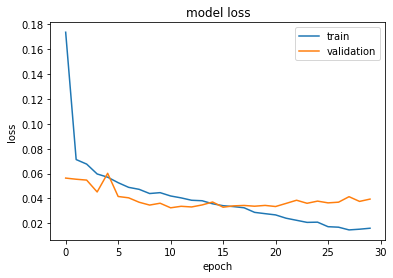

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
Accuracy:  0.98193359375
F1:  0.0437375745526839


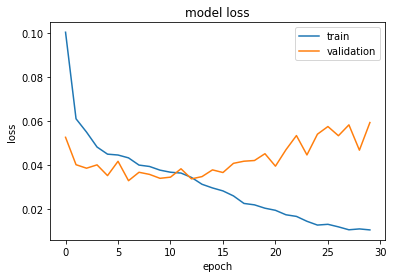

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
Accuracy:  0.98380877508236
F1:  0.039955604883462816


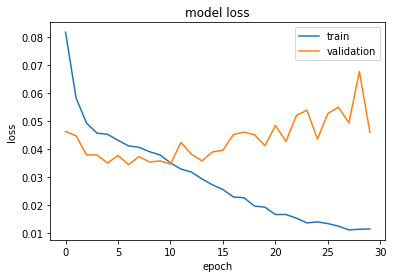

----------------------------------------
Prediction for batch size: 8, sequence lenght: 512
Accuracy:  0.9798677884615384
F1:  0.054673721340388004


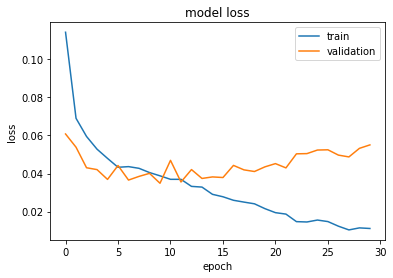

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
Accuracy:  0.97900390625
F1:  0.09105691056910568


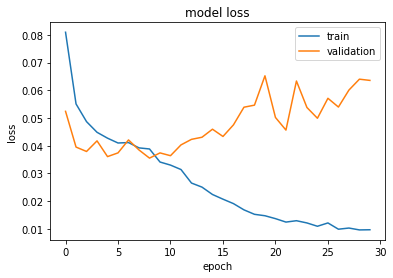

----------------------------------------
Prediction for batch size: 4, sequence lenght: 512
Accuracy:  0.9813889723557693
F1:  0.08831646734130634


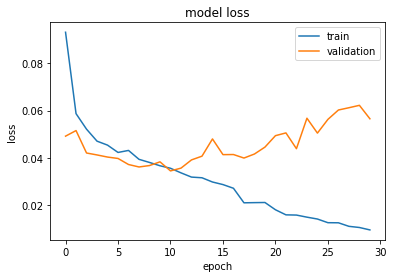

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
Accuracy:  0.9784780649038461
F1:  0.03209459459459459


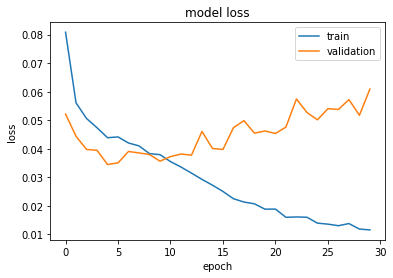

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
Accuracy:  0.9812156950007417
F1:  0.07488584474885844


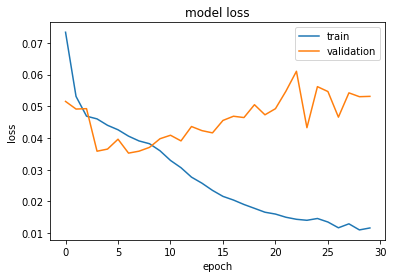

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
Accuracy:  0.9784968449519231
F1:  0.041841004184100423


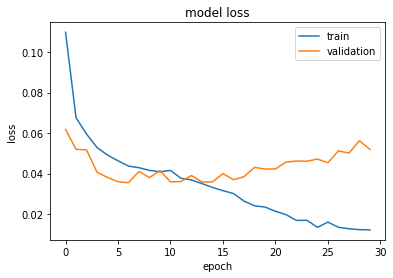

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
Accuracy:  0.981856684981685
F1:  0.0364741641337386


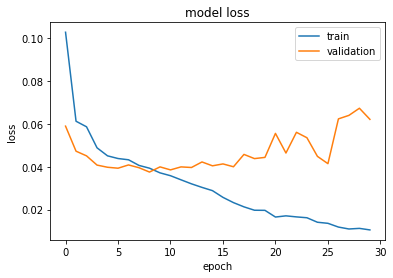

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
Accuracy:  0.9810081845238096
F1:  0.05375347544022243


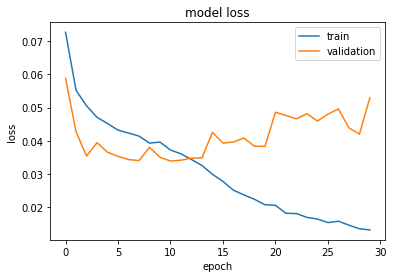

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
Accuracy:  0.9812833234597157
F1:  0.08506787330316742


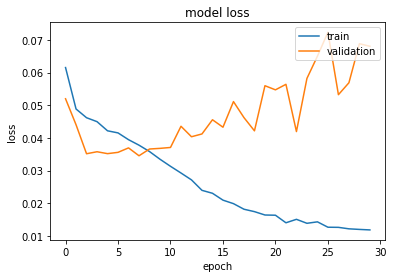

In [74]:
#we retrieve all the information from the files 
import matplotlib.pyplot as plt
import seaborn as sns


for filename in os.listdir(prediction_folder):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(prediction_folder, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(prediction_folder, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(prediction_folder, hist_path_val_loss))
    #thesholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(label_for_prediction_folder, pred_path))
    #print(np.where(tmp_pred > 0.2))
    

    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    accuracy = accuracy_score(sed_gt, tmp_pred_re)
    print("Accuracy: ", accuracy)

    f1 = f1_score(sed_gt, tmp_pred_re, zero_division=1)
    print("F1: ", f1)
    

    # summarize history for loss
    plt.plot(tmp_hist_loss)
    plt.plot(tmp_hist_val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show() 

----------------------------------------
Prediction for batch size: 16, sequence lenght: 512
[[48333   195]
 [  614    10]]


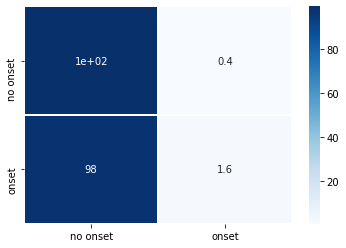

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
[[52264   456]
 [  506    22]]


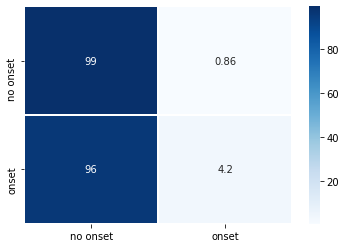

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
[[52541   307]
 [  558    18]]


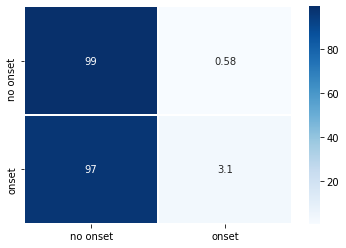

----------------------------------------
Prediction for batch size: 8, sequence lenght: 512
[[52145   383]
 [  689    31]]


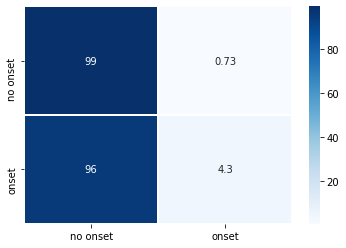

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
[[52074   510]
 [  608    56]]


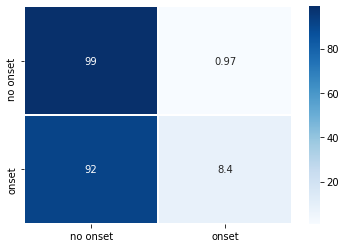

----------------------------------------
Prediction for batch size: 4, sequence lenght: 512
[[52209   363]
 [  628    48]]


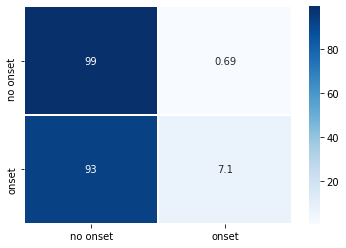

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
[[52083   461]
 [  685    19]]


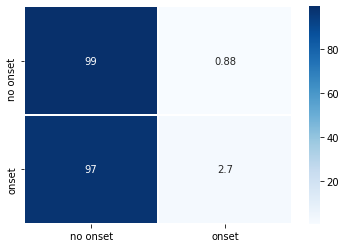

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
[[52874   446]
 [  567    41]]


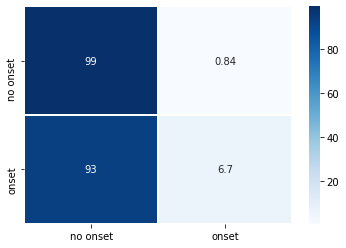

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
[[52078   434]
 [  711    25]]


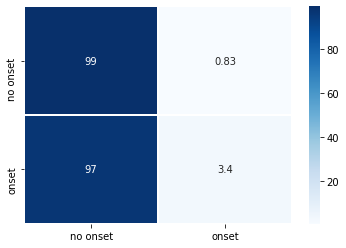

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
[[51447   441]
 [  510    18]]


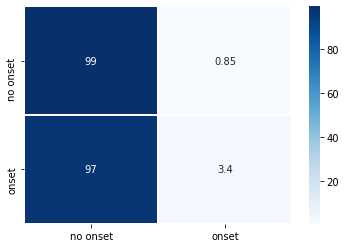

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
[[52710   466]
 [  555    29]]


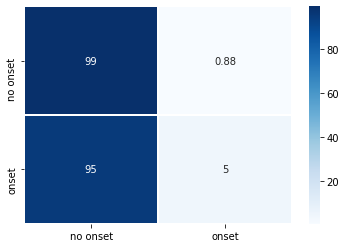

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
[[52958   430]
 [  581    47]]


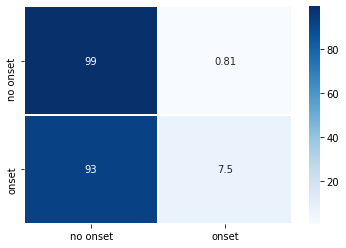

In [75]:
#we retrieve all the information from the files and print the confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns


for filename in os.listdir(prediction_folder):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(prediction_folder, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(prediction_folder, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(prediction_folder, hist_path_val_loss))
    #tresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(label_for_prediction_folder, pred_path))
  

    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    matrix_test = confusion_matrix(sed_gt, tmp_pred_re)
    print(matrix_test) 

    matrix_test_norm = confusion_matrix(sed_gt, tmp_pred_re, normalize='true') * 100 

    ax = sns.heatmap(matrix_test_norm, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['no onset', 'onset'], yticklabels= ['no onset','onset'])
    plt.show()  

## High CRNN archictecture, kernel filter size 6x2

In [0]:
#lets create the folder for the high prediction
dataset_folder = os.path.join('drive/My Drive/dataset_MIR/final_dataset_try_high/')
label_path = dataset_folder + 'labels/'
prediction_folder = dataset_folder + 'predictions'
label_for_prediction_folder = dataset_folder + 'prediction_labels'
create_folder(prediction_folder)
create_folder(label_for_prediction_folder)

In [0]:
from numpy.random import seed
seed(1)
import tensorflow as ts
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPool2D, Input, MaxPooling3D, Conv3D
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

ts.keras.backend.set_image_data_format('channels_last')

def get_model_high(data_in, data_out, dropout_rate, nb_cnn2d_filt, pool_size,
              rnn_size, fnn_size, weights, first):

    #initial dimenison set for channel last
    spec_start = Input(shape=(data_in[2], data_in[3], data_in[1]))
    #dimension for cnn same as the starting point
    spec_cnn = spec_start
    for i, convCount in enumerate(pool_size):
        #convolutional layer - kernel filtr size 6x2
        spec_cnn = Conv2D(filters=nb_cnn2d_filt, kernel_size=(6, 2), padding='same')(spec_cnn)
        spec_cnn = BatchNormalization(trainable=True)(spec_cnn, training=True)
        spec_cnn = Activation('relu')(spec_cnn)
        spec_cnn = MaxPool2D(pool_size=(1, pool_size[i]))(spec_cnn)

    #reshape to a proper dimension for recurrent layers
    spec_rnn = Reshape((data_in[2], 2*nb_cnn2d_filt))(spec_cnn)
    for nb_rnn_filt in rnn_size:
        spec_rnn = Bidirectional(
            GRU(nb_rnn_filt, activation='tanh', dropout=dropout_rate, recurrent_dropout=dropout_rate,
                return_sequences=True, reset_after=False), #reset_after set to false to make it work, default value changed between the two versions
            merge_mode='mul'
        )(spec_rnn, training=True)

    #fc
    sed = spec_rnn
    sed = TimeDistributed(Dense(fnn_size[0]))(sed)
    sed = TimeDistributed(Dense(data_out[-1]))(sed)
    sed = Activation('sigmoid', name='sed_out')(sed)

    model = Model(inputs=spec_start, outputs=[sed])
    model.compile(optimizer=Adam(), loss=['binary_crossentropy'], loss_weights=weights)

    if first:
      model.summary()
    return model

In [39]:
# get all the parameters we will need for the project
nb_epochs = 25 #if changed all the prediction need to be re-done so please delete the file inside the folders and start the code again.
first = 1


#loop trough the different epochs, sequence lenghth and batch size:
for seq_lenght in [512, 256, 126, 64]:
  for batch_size in [16, 8, 4]:
    
    params['sequence_length'] = seq_lenght
    params['batch_size'] = batch_size
    params['nb_epochs'] = nb_epochs
    
    print('-------------------------------------------')
    
    print("Batch size: ", batch_size)
    print("seq_lenght: ", seq_lenght)
    pred_filename = '/pred_{}_{}'.format(batch_size, seq_lenght)
    print("Path to file: ", os.path.join(prediction_folder + pred_filename))

    filename = os.path.join(prediction_folder + pred_filename + '.npy')
    print('file', filename)
    if os.path.exists(filename):
      print("Prediction already done")
    else:

      data_gen_train = DataGenerator(
          nfft=params['nfft'],
          batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='train'
      )


     # generation of testing dataset
      data_gen_test = DataGenerator(
         nfft=params['nfft'],
         batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='test', shuffle=False
      )

      data_in, data_out = data_gen_train.get_data_sizes()

      model = get_model_high(data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                  nb_cnn2d_filt=params['nb_cnn2d_filt'], pool_size=params['pool_size'],
                  rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                  weights=params['loss_weights'], first=first)
    
      #so we do print the model only for the first case 
      first = 0

      gt = collect_test_labels(data_gen_test, data_out, params['quick_test'])
      #reshape to 2D
      sed_gt = reshape_3Dto2D(gt)
      file_path = os.path.join(label_for_prediction_folder + pred_filename + '_lab')
      print("File prediction saved: {}".format(file_path))
      np.save(file_path, sed_gt)
      print("File prediction saved: {}".format(file_path))

     # it returns an history value
     #model fit
      hist = model.fit(
          x=data_gen_train.generate(),
          steps_per_epoch=1 if params['quick_test'] else data_gen_train.get_total_batches_in_data(),
          validation_data=data_gen_test.generate(),
          validation_steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          epochs=nb_epochs,
          verbose=1)



      #model prediction
      pred = model.predict(
          x=data_gen_test.generate(),
          steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          verbose=0
      )

    
      #training loss values
      hist_loss_filename = os.path.join(high_pred_path + pred_filename) + '_hist_loss'
      np.save(hist_loss_filename, hist.history['loss'])
      print("File prediction loss saved {}".format(os.path.join(high_pred_path + hist_loss_filename)))
      #validation loss values
      hist_val_loss_filename = os.path.join(high_pred_path + pred_filename) + '_hist_val_loss'
      np.save(hist_val_loss_filename, hist.history['val_loss'])
      print("File prediction val_loss saved {}".format(os.path.join(high_pred_path + hist_val_loss_filename))) 
      #prediction
      np.save(os.path.join(high_pred_path + pred_filename), pred)
      print("File prediction saved {}".format(os.path.join(high_pred_path + pred_filename)))

-------------------------------------------
Batch size:  16
seq_lenght:  512
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try_high/predictions/pred_16_512
file drive/My Drive/dataset_MIR/final_dataset_try_high/predictions/pred_16_512.npy
Prediction already done
-------------------------------------------
Batch size:  8
seq_lenght:  512
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try_high/predictions/pred_8_512
file drive/My Drive/dataset_MIR/final_dataset_try_high/predictions/pred_8_512.npy
Prediction already done
-------------------------------------------
Batch size:  4
seq_lenght:  512
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try_high/predictions/pred_4_512
file drive/My Drive/dataset_MIR/final_dataset_try_high/predictions/pred_4_512.npy
Prediction already done
-------------------------------------------
Batch size:  16
seq_lenght:  256
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try_high/predictions/pred_16_256
file drive/My Drive/d

## Evaluation high CRNN architecture 

The network will be evaluated in terms of accurcay and F1-score

----------------------------------------
Prediction for batch size: 16, sequence lenght: 512
Accuracy:  0.9785359700520834
F1:  0.027649769585253458


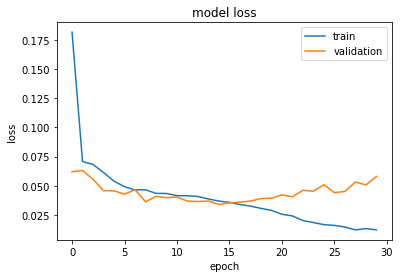

----------------------------------------
Prediction for batch size: 8, sequence lenght: 512
Accuracy:  0.9825345552884616
F1:  0.03925619834710743


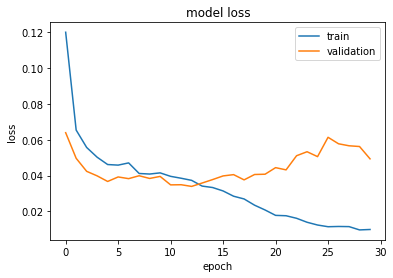

----------------------------------------
Prediction for batch size: 4, sequence lenght: 512
Accuracy:  0.9828350360576923
F1:  0.07489878542510121


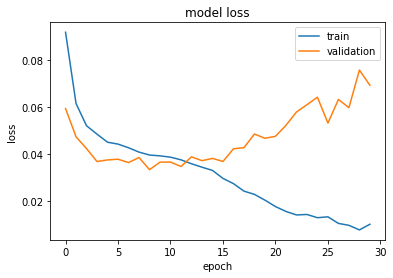

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
Accuracy:  0.9789851262019231
F1:  0.027801911381407467


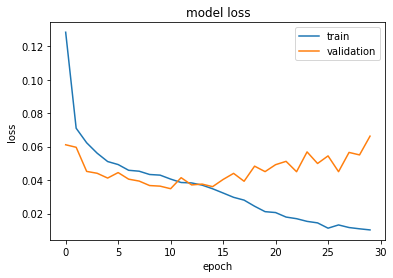

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
Accuracy:  0.9833420973557693
F1:  0.04520990312163617


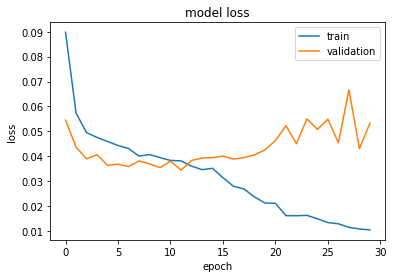

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
Accuracy:  0.9818584735576923
F1:  0.08349146110056926


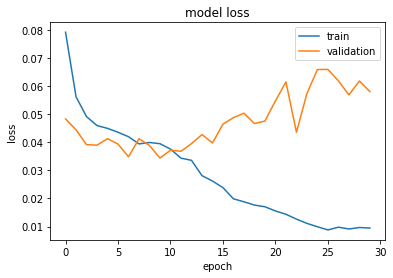

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
Accuracy:  0.9836881868131868
F1:  0.02508551881413911


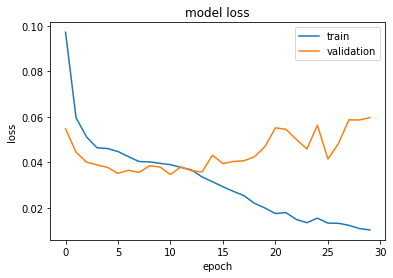

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
Accuracy:  0.9816000299490866
F1:  0.053897978825794036


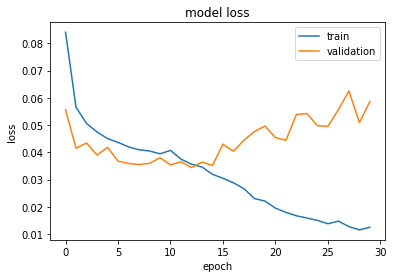

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
Accuracy:  0.9808448301438956
F1:  0.10095735422106179


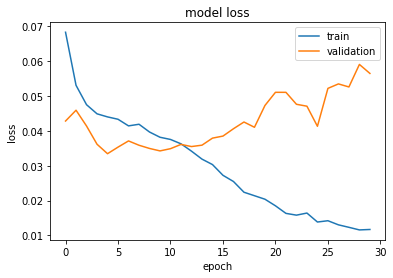

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
Accuracy:  0.9820650540865384
F1:  0.024514811031664963


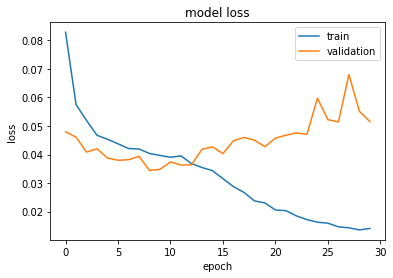

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
Accuracy:  0.9817708333333334
F1:  0.04854368932038835


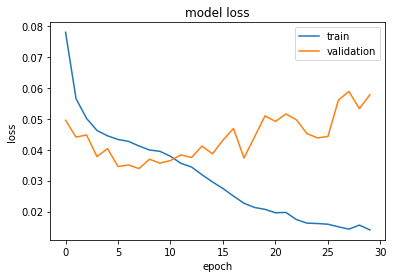

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
Accuracy:  0.9820238447867299
F1:  0.03383084577114427


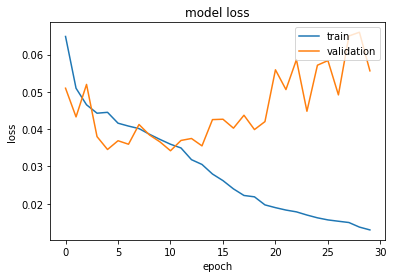

In [40]:
#we retrieve all the information from the files 
import matplotlib.pyplot as plt
import seaborn as sns


for filename in os.listdir(prediction_folder):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(prediction_folder, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(prediction_folder, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(prediction_folder, hist_path_val_loss))
    #tresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(label_for_prediction_folder, pred_path))


    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    accuracy = accuracy_score(sed_gt, tmp_pred_re)
    print("Accuracy: ", accuracy)

    f1 = f1_score(sed_gt, tmp_pred_re, zero_division=1)
    print("F1: ", f1)


    # summarize history for loss
    plt.plot(tmp_hist_loss)
    plt.plot(tmp_hist_val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()  

----------------------------------------
Prediction for batch size: 16, sequence lenght: 512
ERROR! Session/line number was not unique in database. History logging moved to new session 60
[[48082   382]
 [  673    15]]


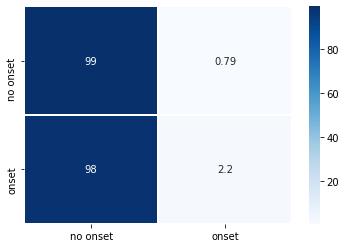

----------------------------------------
Prediction for batch size: 8, sequence lenght: 512
[[52299   301]
 [  629    19]]


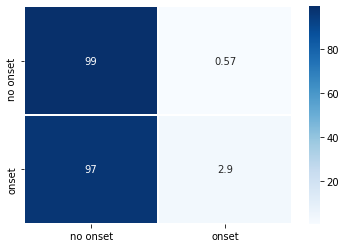

----------------------------------------
Prediction for batch size: 4, sequence lenght: 512
[[52297   343]
 [  571    37]]


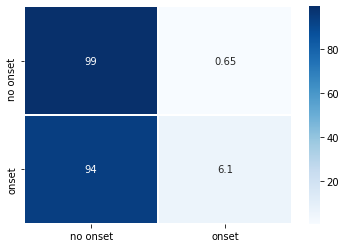

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
[[52113   463]
 [  656    16]]


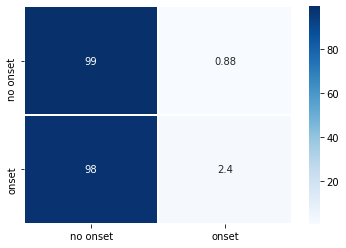

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
[[52340   300]
 [  587    21]]


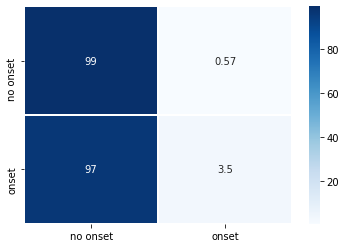

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
[[52238   410]
 [  556    44]]


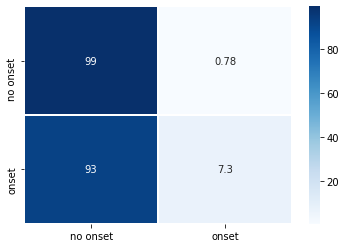

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
[[51550   354]
 [  501    11]]


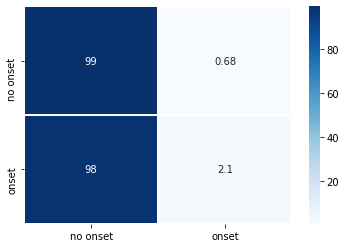

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
[[52413   411]
 [  572    28]]


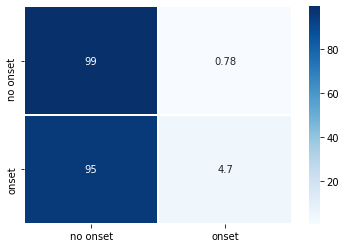

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
[[52837   423]
 [  610    58]]


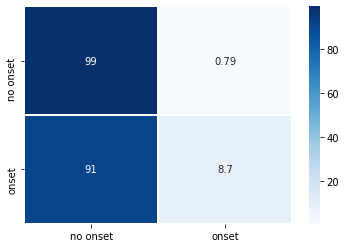

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
[[52281   359]
 [  596    12]]


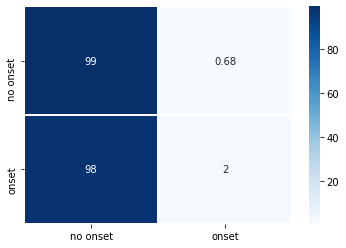

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
[[52755   429]
 [  551    25]]


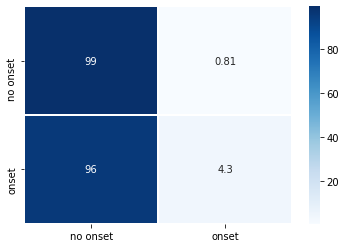

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
[[53028   316]
 [  655    17]]


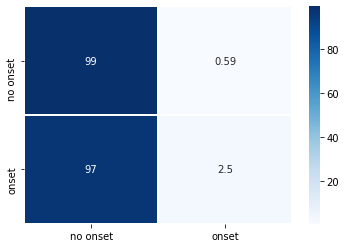

In [41]:
#we retrieve all the information from the files and plot the confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns


for filename in os.listdir(prediction_folder):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(prediction_folder, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(prediction_folder, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(prediction_folder, hist_path_val_loss))
    #tresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(label_for_prediction_folder, pred_path))
    

    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    matrix_test = confusion_matrix(sed_gt, tmp_pred_re)
    print(matrix_test) 


    matrix_test_norm = confusion_matrix(sed_gt, tmp_pred_re, normalize='true') * 100

    ax = sns.heatmap(matrix_test_norm, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['no onset', 'onset'], yticklabels= ['no onset','onset'])
    plt.show()




    

     

## Wide CRNN architecture, kernel filter size 6X2 


In [0]:
#folder where the predictions will be saved
dataset_folder = os.path.join('drive/My Drive/dataset_MIR/final_dataset_try_wide/')
prediction_folder = dataset_folder + 'predictions'
label_for_prediction_folder = dataset_folder + 'prediction_labels'
create_folder(prediction_folder)
create_folder(label_for_prediction_folder)

In [0]:
from numpy.random import seed
seed(1)
import tensorflow as ts
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPool2D, Input, MaxPooling3D, Conv3D
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

ts.keras.backend.set_image_data_format('channels_last')

def get_model_wide(data_in, data_out, dropout_rate, nb_cnn2d_filt, pool_size,
              rnn_size, fnn_size, weights, first):

    #initial dimenison set for channel last
    spec_start = Input(shape=(data_in[2], data_in[3], data_in[1]))
    #dimension for cnn same as the starting point
    spec_cnn = spec_start
    for i, convCount in enumerate(pool_size):
        #convolutional layer - wide filkter size
        spec_cnn = Conv2D(filters=nb_cnn2d_filt, kernel_size=(2, 6), padding='same')(spec_cnn)
        spec_cnn = BatchNormalization(trainable=True)(spec_cnn, training=True)
        spec_cnn = Activation('relu')(spec_cnn)
        spec_cnn = MaxPool2D(pool_size=(1, pool_size[i]))(spec_cnn)

    #reshape to a proper dimension for recurrent layers
    spec_rnn = Reshape((data_in[2], 2*nb_cnn2d_filt))(spec_cnn)

    for nb_rnn_filt in rnn_size:
        spec_rnn = Bidirectional(
            GRU(nb_rnn_filt, activation='tanh', dropout=dropout_rate, recurrent_dropout=dropout_rate,
                return_sequences=True, reset_after=False), 
            merge_mode='mul'
        )(spec_rnn, training=True)

    #FC
    sed = spec_rnn
    sed = TimeDistributed(Dense(fnn_size[0]))(sed)
    sed = TimeDistributed(Dense(data_out[-1]))(sed)
    sed = Activation('sigmoid', name='sed_out')(sed)

    model = Model(inputs=spec_start, outputs=[sed])
    model.compile(optimizer=Adam(), loss=['binary_crossentropy'], loss_weights=weights)

    if first:
      model.summary()
    return model

In [78]:
import numpy as np
from numpy.random import seed
seed(1)
import sys
import os
import time
import matplotlib.pyplot as plot
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# get all the parameters i need for the project
nb_epochs = 25 #if changed all the prediction need to be re-done so please delete the file inside the folders and start the code again. 
first = 1


#loop trough the different epochs, sequence lenghth and batch size:
for seq_lenght in [512, 256, 126, 64]:
  for batch_size in [16, 8, 4]:
    
    params['sequence_length'] = seq_lenght
    params['batch_size'] = batch_size
    params['nb_epochs'] = nb_epochs
    
    print('-------------------------------------------')
    
    print("Batch size: ", batch_size)
    print("seq_lenght: ", seq_lenght)
    pred_filename = '/pred_{}_{}'.format(batch_size, seq_lenght)
    print("Path to file: ", os.path.join(prediction_folder + pred_filename))

    filename = os.path.join(prediction_folder + pred_filename + '.npy')
    print('file', filename)
    if os.path.exists(filename):
      print("Prediction already done")
    else:

      data_gen_train = DataGenerator(
          nfft=params['nfft'],
          batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='train'
      )


     # generation of testing dataset
      data_gen_test = DataGenerator(
         nfft=params['nfft'],
         batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='test', shuffle=False
      )

      data_in, data_out = data_gen_train.get_data_sizes()

      model = get_model_wide(data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                  nb_cnn2d_filt=params['nb_cnn2d_filt'], pool_size=params['pool_size'],
                  rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                  weights=params['loss_weights'], first=first)
    
      #so we do print the model only for the first case 
      first = 0

      gt = collect_test_labels(data_gen_test, data_out, params['quick_test'])
      #reshape to 2D
      sed_gt = reshape_3Dto2D(gt)
      file_path = os.path.join(label_for_prediction_folder + pred_filename + '_lab')
      print("File prediction saved: {}".format(file_path))
      np.save(file_path, sed_gt)
      print("File prediction saved: {}".format(file_path))

      # it returns an history value
     #model fit
      hist = model.fit(
          x=data_gen_train.generate(),
          steps_per_epoch=1 if params['quick_test'] else data_gen_train.get_total_batches_in_data(),
          validation_data=data_gen_test.generate(),
          validation_steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          epochs=nb_epochs,
          verbose=1)



      #model prediction
      pred = model.predict(
          x=data_gen_test.generate(),
          steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          verbose=0
      )

    
      #training loss values
      hist_loss_filename = os.path.join(wide_pred_path + pred_filename) + '_hist_loss'
      np.save(hist_loss_filename, hist.history['loss'])
      print("File prediction loss saved {}".format(os.path.join(wide_pred_path + hist_loss_filename)))
      #validation loss values
      hist_val_loss_filename = os.path.join(wide_pred_path + pred_filename) + '_hist_val_loss'
      np.save(hist_val_loss_filename, hist.history['val_loss'])
      print("File prediction val_loss saved {}".format(os.path.join(wide_pred_path + hist_val_loss_filename)))
      #predictions 
      np.save(os.path.join(wide_pred_path + pred_filename), pred)
      print("File prediction saved {}".format(os.path.join(wide_pred_path + pred_filename)))

-------------------------------------------
Batch size:  16
seq_lenght:  512
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try_wide/predictions/pred_16_512
file drive/My Drive/dataset_MIR/final_dataset_try_wide/predictions/pred_16_512.npy
Prediction already done
-------------------------------------------
Batch size:  8
seq_lenght:  512
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try_wide/predictions/pred_8_512
file drive/My Drive/dataset_MIR/final_dataset_try_wide/predictions/pred_8_512.npy
Prediction already done
-------------------------------------------
Batch size:  4
seq_lenght:  512
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try_wide/predictions/pred_4_512
file drive/My Drive/dataset_MIR/final_dataset_try_wide/predictions/pred_4_512.npy
Prediction already done
-------------------------------------------
Batch size:  16
seq_lenght:  256
Path to file:  drive/My Drive/dataset_MIR/final_dataset_try_wide/predictions/pred_16_256
file drive/My Drive/d

## Evaluation wide CRNN architecture

Evaluation in terms of F1-score and accuracy, printing all the confusion matrices

----------------------------------------
Prediction for batch size: 16, sequence lenght: 512
Accuracy:  0.9844563802083334
F1:  0.012919896640826874


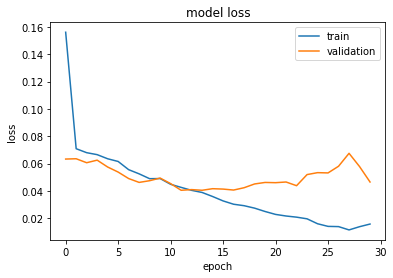

----------------------------------------
Prediction for batch size: 8, sequence lenght: 512
Accuracy:  0.9830228365384616
F1:  0.03624733475479744


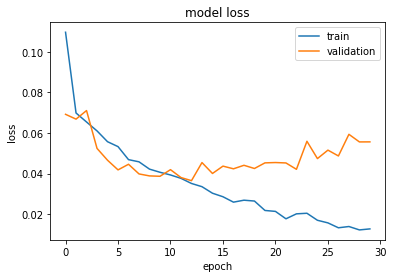

----------------------------------------
Prediction for batch size: 4, sequence lenght: 512
Accuracy:  0.9815392127403846
F1:  0.07525870178739416


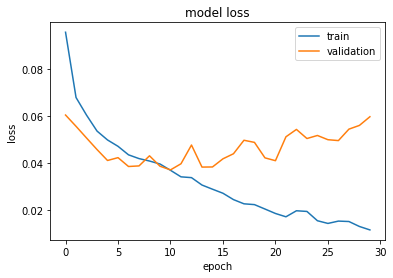

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
Accuracy:  0.9809006911057693
F1:  0.013579049466537343


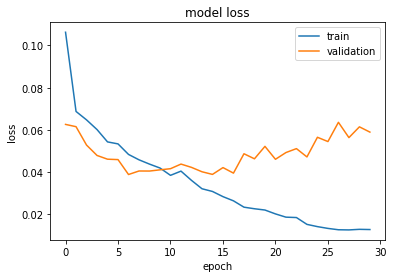

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
Accuracy:  0.9801682692307693
F1:  0.053763440860215055


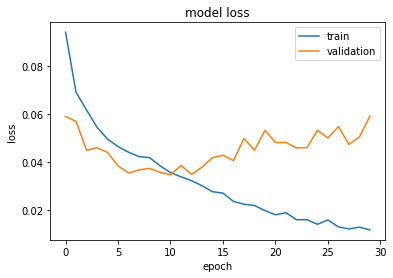

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
Accuracy:  0.9833233173076923
F1:  0.08264462809917356


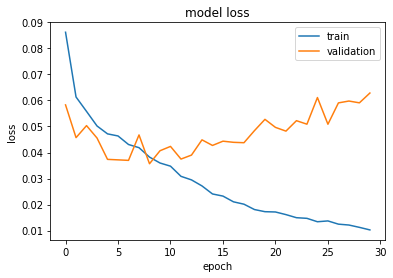

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
Accuracy:  0.9784607753357754
F1:  0.035866780529462


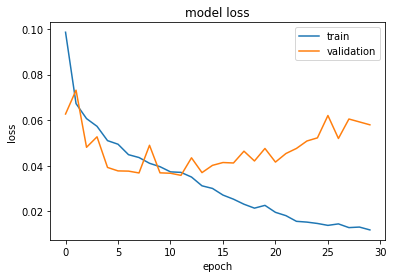

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
Accuracy:  0.9812818209044624
F1:  0.06542056074766354


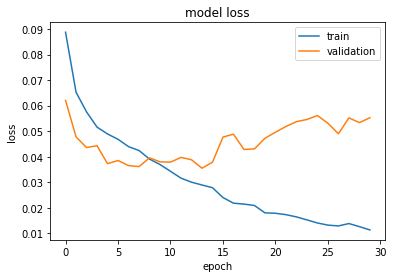

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
Accuracy:  0.9828845868565494
F1:  0.09951219512195122


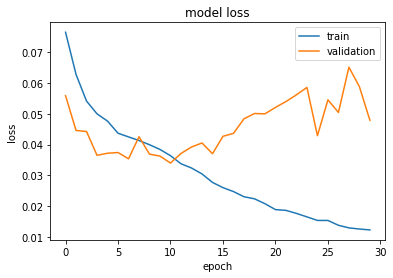

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
Accuracy:  0.9830228365384616
F1:  0.015250544662309368


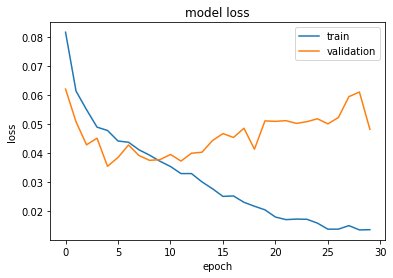

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
Accuracy:  0.9799665178571428
F1:  0.037533512064343154


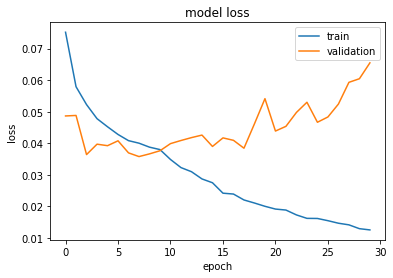

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
Accuracy:  0.9793209419431279
F1:  0.08964955175224124


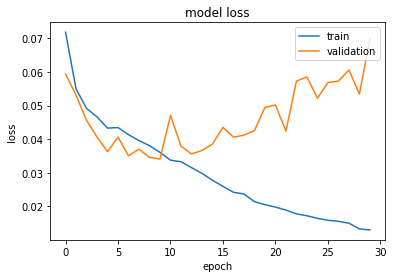

In [79]:
#we retrieve all the information from the files and print accuracy and F1-score
import matplotlib.pyplot as plt
import seaborn as sns


for filename in os.listdir(prediction_folder):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(prediction_folder, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(prediction_folder, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(prediction_folder, hist_path_val_loss))
    #thresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(label_for_prediction_folder, pred_path))
    

    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    accuracy = accuracy_score(sed_gt, tmp_pred_re)
    print("Accuracy: ", accuracy)

    f1 = f1_score(sed_gt, tmp_pred_re, zero_division=1)
    print("F1: ", f1)


    # summarize history for loss
    plt.plot(tmp_hist_loss)
    plt.plot(tmp_hist_val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


----------------------------------------
Prediction for batch size: 16, sequence lenght: 512
[[48383   257]
 [  507     5]]


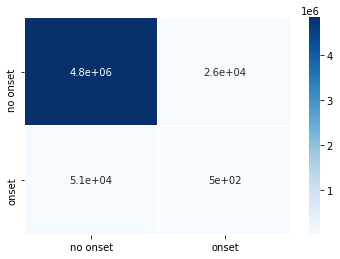

----------------------------------------
Prediction for batch size: 8, sequence lenght: 512
[[52327   369]
 [  535    17]]


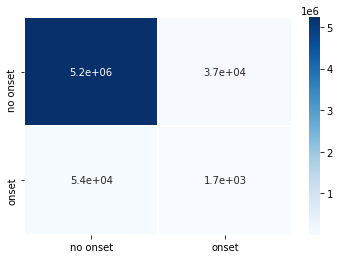

----------------------------------------
Prediction for batch size: 4, sequence lenght: 512
[[52225   383]
 [  600    40]]


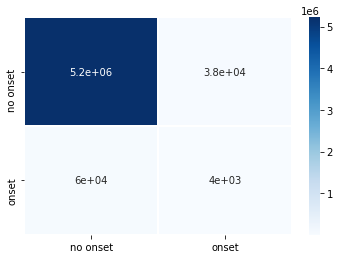

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
[[52224   432]
 [  585     7]]


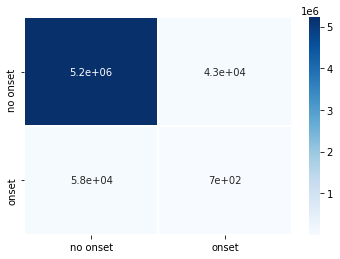

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
[[52162   406]
 [  650    30]]


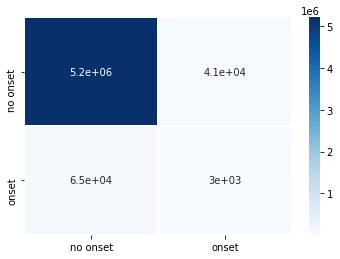

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
[[52320   332]
 [  556    40]]


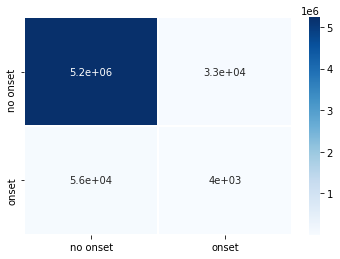

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
[[51266   446]
 [  683    21]]


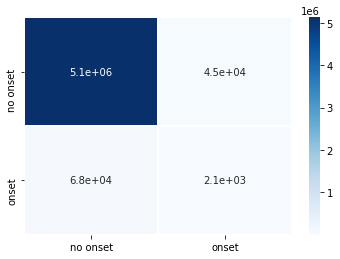

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
[[52389   379]
 [  621    35]]


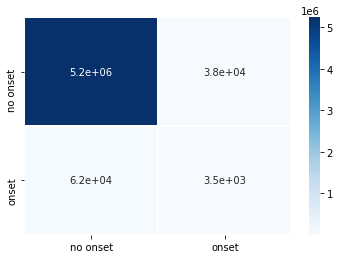

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
[[52954   310]
 [  613    51]]


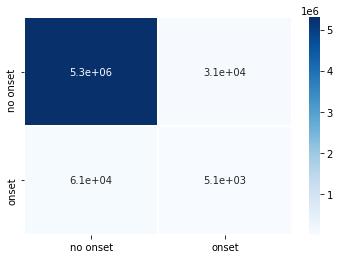

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
[[52337   271]
 [  633     7]]


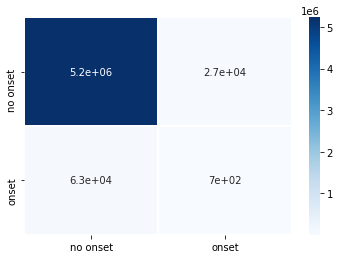

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
[[52662   482]
 [  595    21]]


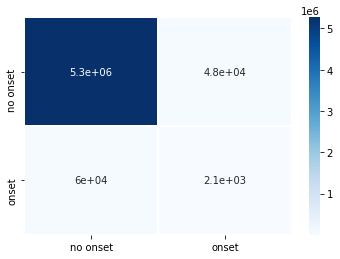

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
[[52844   492]
 [  625    55]]


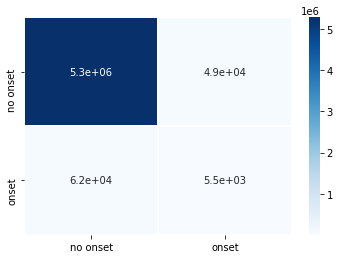

In [80]:
#we retrieve all the information from the files and plot all the confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns


for filename in os.listdir(prediction_folder):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(prediction_folder, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(prediction_folder, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(prediction_folder, hist_path_val_loss))
    #thresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(label_for_prediction_folder, pred_path))
    

    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))
    matrix_test = confusion_matrix(sed_gt, tmp_pred_re)
    print(matrix_test) 

    matrix_test_norm = confusion_matrix(sed_gt, tmp_pred_re) * 100

    ax = sns.heatmap(matrix_test_norm, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['no onset', 'onset'], yticklabels= ['no onset','onset'])
    plt.show()